# Discretizing and Solving the Aiyagari Model: Some Examples

The goal of this notebook is to provide some easy examples on how to solve an incomplete market model in the Steady State. 




In [1]:
# Define the packages used in the notebook
# P.S currently tested on 3.11.3 python version, but these are standard packages and should work well in other version as well.
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit, guvectorize # NUMBA speed up quite a lot, see the functions that have the decorator just above
from scipy.optimize import brentq  # root-finding routine
from scipy.stats import norm

# Matplotlib par
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 12})

path = '/Users/tomasrm/Library/CloudStorage/Dropbox/Teaching/Insper/AdvancedMacro/Codes/Plots' # this is only used to save plots


#### Discretization the asset space

The first step to solve the household using global methods is to discretize the asset space. Write a function that discretize the asset space in $n_A$ grid points:




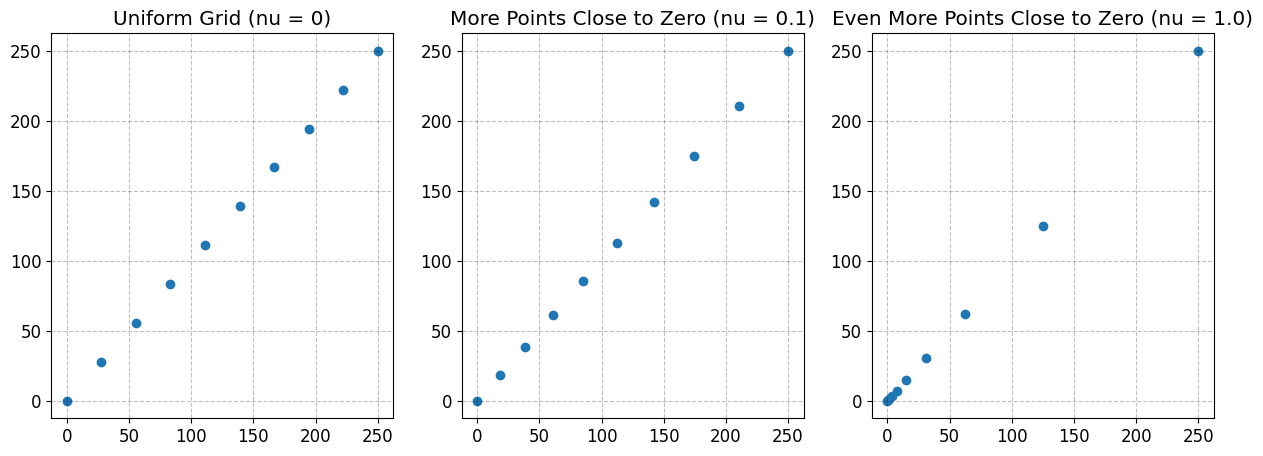

In [2]:

# Write a function:
def CreateGrid(nA, amin, amax, grid_growth): 
    if grid_growth == 0.0:
        gA =  np.linspace(amin, amax, nA)
    elif grid_growth > 0.0:
        gA = np.zeros(nA)
        for i in range(nA):
            gA[i] = amin + (amax - amin)*((1 + grid_growth)**i -1)/((1 + grid_growth)**(nA-1.0) -1)
    return gA
    
# Let's illustrate: 

nA = 10 # Number of grid points
amin = 0.0 # Borrowing constraint
amax = 250.0 # Maximum asset grid -> make sure it does not bind!!!
grid_growth_uniform = 0.0 # controls the curvature of the points
grid_growth_curvature = 0.1 
grid_growth_even_more_curvature = 1.0 

gA_0 = CreateGrid(nA, amin, amax, grid_growth_uniform)
gA_1 = CreateGrid(nA, amin, amax, grid_growth_curvature)
gA_2 = CreateGrid(nA, amin, amax, grid_growth_even_more_curvature)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
ax1.scatter(gA_0, gA_0)
ax1.set_title("Uniform Grid (nu = 0)")  
ax2.scatter(gA_1, gA_1)
ax2.set_title("More Points Close to Zero (nu = 0.1)")  
ax3.scatter(gA_2, gA_2)
ax3.set_title("Even More Points Close to Zero (nu = 1.0)")  

plt.savefig(path + "/grid_curvature.png", bbox_inches='tight')


#### Discretization the earnings space

In the simplest model, earnings are usually modelled as a stochastic process. Consider the simplest case, where labor earnings follow an stochastic process:

$s_t = \mu + \rho s_{t-1} + \sigma \varepsilon_t$,

where $\varepsilon \sim (0,1)$. The two standard methods to discretize the AR(1) are Tauchen and Rowenhorst. For non-standard processes such non-stationary (i.e., life cycle) or higher-moments see the references in the lecture notes.

In practice, the Rowenhorst method is better for highly persistent processes ($\rho > 0.9$), which is usually the case for the income process. 



In [3]:
def rouwenhorst(N, rho, sigma, mu=0.0):
    """Rouwenhorst method to discretize AR(1) process"""

    q = (rho + 1)/2
    nu = ((N-1.0)/(1.0-rho**2))**(1/2)*sigma
    s = np.linspace(mu/(1.0-rho)-nu, mu/(1.0-rho)+nu, N) # states

    # implement recursively transition matrix
    P = np.array([[q, 1-q], [1-q, q]])

    for i in range(2,N): # add one row/column one by one
        P = q*np.r_[np.c_[P, np.zeros(i)] , [np.zeros(i+1)]] + (1-q)*np.r_[np.c_[np.zeros(i), P] , [np.zeros(i+1)]] + (1-q)*np.r_[[np.zeros(i+1)] ,  np.c_[P, np.zeros(i)]] + q*np.r_[[np.zeros(i+1)] ,  np.c_[np.zeros(i), P]]
        P[1:i,:]=P[1:i,:]/2  # adjust the middle rows of the matrix

    # compute invariant distribution of process (by iteration)
    inv = np.ones(N) / N # initial guess
    tol=1E-11; maxit=100^4
    for it in range(maxit):
        inv_new = inv @ P
        if np.max(np.abs(inv_new - inv)) < tol: break  
        inv = inv_new # invariant distribution

    return s, P, inv


def tauchen(N, rho, sigma, mu=0.0, m=3.0):
    """Tauchen method to discretize AR(1) process"""

    s1 = mu/(1 - rho) - m * np.sqrt(sigma**2 / (1 - rho**2))
    sN = mu/(1 - rho) + m * np.sqrt(sigma**2 / (1 - rho**2))
    s = np.linspace(s1, sN, N) # grid values
    step = (s[N-1] - s[0]) / (N - 1)  # evenly spaced grid
    P = np.zeros((N, N))

    for i in range(np.ceil(N/2).astype(int)):
        P[i, 0] = norm.cdf((s[0] - mu - rho*s[i] + step/2) / sigma)
        P[i, N-1] = 1 - norm.cdf((s[N-1] - mu - rho*s[i] - step/2) / sigma)
        for j in range(1, N-1):
            P[i, j] = norm.cdf((s[j] - mu - rho*s[i] + step/2) / sigma) - \
                      norm.cdf((s[j] - mu - rho*s[i] - step/2) / sigma)
    P[np.floor((N-1)/2+1).astype(int):, :] = P[0:np.ceil((N-1)/2).astype(int), :][::-1, ::-1]

    ps = np.sum(P, axis=1)
    P = P / ps[:, np.newaxis] # transition matrix

    # compute invariant distribution of process (by iteration)
    inv = np.ones(N) / N # initial guess
    tol=1E-11; maxit=100^4
    for it in range(maxit):
        inv_new = inv @ P
        if np.max(np.abs(inv_new - inv)) < tol: break  
        inv = inv_new # invariant distribution

    return s, P, inv

# ===== Comparison between the two methods: 
N = 5
rho = 0.9
sigma = 0.1 

s1, prob1, inv1 = rouwenhorst(N, rho, sigma)
s2, prob2, inv2 = tauchen(N, rho, sigma)

print("States:")
print("Rouwenhorst: ", s1)
print("Tauchen:     ", s2)

print("\nTransition Matrix (third row):")
print("Rouwenhorst: ", prob1[2,:])
print("Tauchen:     ", prob2[2,:])

print("\nInvariant Distribution:")
print("Rouwenhorst: ", inv1)
print("Tauchen:     ", inv2)



States:
Rouwenhorst:  [-0.45883147 -0.22941573  0.          0.22941573  0.45883147]
Tauchen:      [-0.6882472 -0.3441236  0.         0.3441236  0.6882472]

Transition Matrix (third row):
Rouwenhorst:  [0.00225625 0.085975   0.8235375  0.085975   0.00225625]
Tauchen:      [1.22257976e-07 4.26599599e-02 9.14679836e-01 4.26599599e-02
 1.22257976e-07]

Invariant Distribution:
Rouwenhorst:  [0.0625 0.25   0.375  0.25   0.0625]
Tauchen:      [0.0304637  0.236133   0.46680659 0.236133   0.0304637 ]


#### Solving the Consumption-savings Problem

We are interested in solving the following problem: 

\begin{align}
V(a, s) &= \max_{a' \geq -\phi} \{u((1+r)a + w\exp{s} -a' ) + \beta\mathbb{E}[V(a', s')|s] \},
\end{align}

in particular, we want to find the consumption, $g_c(a, s)$, and savings policy function, $g_a(a, s)$.

Theoretically, we know that the solution implies the Euler Equation:

$u'(c) < \beta (1+r) \mathbb{E}[u(c') | s]$, 

which holds with equality if $a' > -\phi$.

We will illustrate how to solve the problem using the Endogenous Grid Method:





In [71]:
# This function is for fast linear interpolação (I took this function from state-space Jacobian package)
@guvectorize(['void(float64[:], float64[:], float64[:], float64[:])'], '(n),(nq),(n)->(nq)')
def interpolate_y(x, xq, y, yq):
    """Efficient linear interpolation exploiting monotonicity.
    Complexity O(n+nq), so most efficient when x and xq have comparable number of points.
    Extrapolates linearly when xq out of domain of x.
    Parameters
    ----------
    x  : array (n), ascending data points 
    xq : array (nq), ascending query points
    y  : array (n), data points
    Returns
    ----------
    yq : array (nq), interpolated points
    
    We have a function y=f(x), and some points xq. We use xq points to find yq.
    """
    nxq, nx = xq.shape[0], x.shape[0]

    xi = 0
    x_low = x[0]
    x_high = x[1]
    for xqi_cur in range(nxq):
        xq_cur = xq[xqi_cur]
        while xi < nx - 2:
            if x_high >= xq_cur:
                break
            xi += 1
            x_low = x_high
            x_high = x[xi + 1]

        xqpi_cur = (x_high - xq_cur) / (x_high - x_low)
        yq[xqi_cur] = xqpi_cur * y[xi] + (1 - xqpi_cur) * y[xi + 1]




Tol. achieved (EGM): 9.670486633694964e-12, Iteration: 473


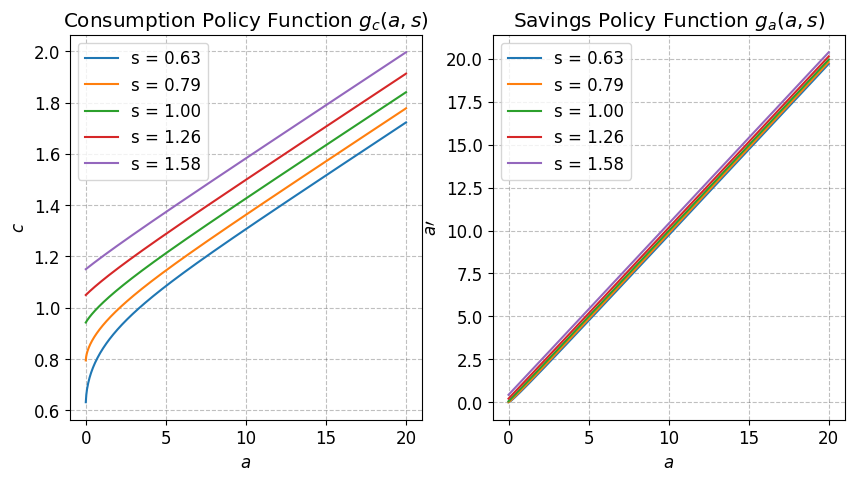

In [213]:
## Prices (This would be guesses in the loop)
r = 0.04 
w = 1.0 

# Parameters
nA = 300
amin = 0.0 # borrowing constraint
amax = 20
grid_growth = 0.010
gA = CreateGrid(nA, amin, amax, grid_growth)

nS = 5
sigma = 0.1
rho = 0.9
gS, transS, _ = rouwenhorst(nS, rho, sigma)
gS = np.exp(gS)

beta = 0.96  # discount factor
gamma = 2.0 # intertemporal elasticity of substitution


def EndogenousGridMethod(r, w, nA, gA, nS, gS, transS, beta, gamma):
    # Iteration parameters
    maxiter = 2000
    tol = 1E-11 # tolerance

    # Useful matrices: rows are the asset state, columns are 
    gAA = np.repeat(gA, nS).reshape((nA, nS)) # nA x nS matrix of asset grid.
    gSS = np.repeat(gS, nA).reshape((nS, nA)).T # nA x nS matrix of labor grid. Note the transpose.
    gYY = w * gSS + (1.0 + r) * gAA # nA x nS matrix of cash on hand grid.
    
    # Pre-allocate value and policy funcctions
    cp = gYY - gAA  # consumption policy. Dimension nA x nS
    ap = np.zeros((nA, nS))   # asset policy
    endogAA = np.zeros((nA, nS))  # endogenous asset grid

    for iter in range(maxiter):
        # ===== Perform EGM ===== #
        expect = beta * (1.0 + r) * np.matmul( cp**(-gamma) , transS.T)  # Right hand side of Euler Eq., 
        c = expect**(-1.0/gamma)    # Invert marginal util to get contemporaneous C
        endogAA = (c + gAA - w * gSS) / (1 + r)  # compute asset state on endogenous grid (note that gAA is the policy function, which is on-grid)  
        
        # === Interpolate to find the correct asset policy function
        apNew = np.zeros((nA, nS)) # here we store the policy function that we interpolate

        for iS in range(nS):
            interpolate_y(endogAA[:, iS], gA, gA, apNew[:, iS]) # perform interpolation -> we have "gA" (third argument) that is defined on the endogenous grid "endogAA", we want to find "apNew" defined on the exogenous grid "gA" (second argument).
            # Must account for the binding constraint!
            for ia in range(nA):
                if apNew[ia, iS] < gA[0]: apNew[ia, iS] = gA[0]
                else: break  # exploit monotinicity of ia.

        cpNew = gYY - apNew  # get updated consumption policy

        # ===== Check if policuufunction has converged =====
        d = np.amax(np.abs(cp - cpNew))
        cp = cpNew
        ap = apNew

        #print("Iter: ", iter, "Tol. ", d) # uncomment to see the 

        if d < tol:
            print(f"Tol. achieved (EGM): {d}, Iteration: {iter}")
            break  # break the loop in case we found the Policy Function!
    
        if iter == maxiter:
            print("Max iterations achieved. EGM did not converge")

    return ap, cp, endogAA 
    
ap, cp, endogAA = EndogenousGridMethod(r, w, nA, gA, nS, gS, transS, beta, gamma)

# Plot consumption function (ps. I got the settings from Jeppe Druedahl)
#fig = plt.figure()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5)) # Ax1 is consumption ax2 is savings

for s in range(nS):
    ax1.plot(gA,cp[:,s],label=f's = {gS[s]:.2f}'  )
    ax2.plot(gA,ap[:,s],label=f's = {gS[s]:.2f}'  )

ax1.legend(frameon=True)
ax1.set_xlabel('$a$')
ax1.set_ylabel('$c$')
ax1.set_title('Consumption Policy Function $g_c(a,s)$')  

ax2.legend(frameon=True)
ax2.set_xlabel('$a$')
ax2.set_ylabel('$a\prime$')
ax2.set_title('Savings Policy Function $g_a(a,s)$')  

#fig.tight_layout(pad=0.5)
plt.savefig(path + "/policy_func.png", bbox_inches='tight')


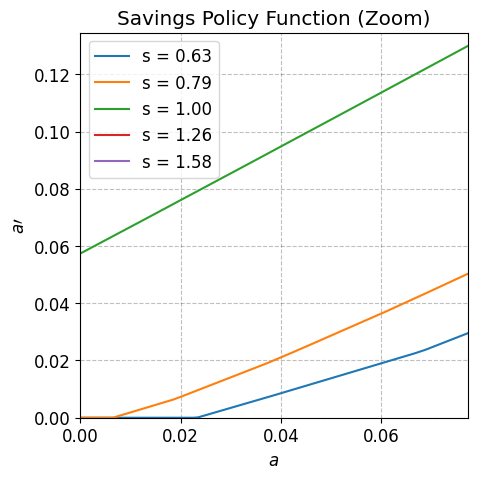

In [150]:
# Zoom in the borrowing constraint of the Savings Policy

fig, ax2 = plt.subplots(1,1,figsize=(5, 5)) # Ax1 is consumption ax2 is savings

for s in range(nS):
    ax2.plot(gA,ap[:,s],label=f's = {gS[s]:.2f}'  )
ax2.legend(frameon=True)
ax2.set_xlabel('$a$')
ax2.set_ylabel('$a\prime$')
ax2.set_title('Savings Policy Function (Zoom)')  
ax2.set_xlim([gA[0],gA[80]])
ax2.set_ylim([gA[0],gA[100]])

plt.savefig(path + "/zoom_policy_func.png", bbox_inches='tight')


You can interpolate the asset policy function as before, or the consumption policy function as the following function. You can also interpolate on the asset grid or in the cash-in-hand grid, whatever is more convenient in your problem.
Finally, you can also use the f.o.c of the dynamic programming $u'(g_c(a, s)) = \beta \mathbb{E[V_a(a',s')|s]}$, and iterate on the value function. 

In [214]:
# In this function, we interpolate the consumption policy function
def EndogenousGridMethod_on_Consumption(r, w, nA, gA, nS, gS, transS, beta, gamma):
    # Iteration parameters
    maxiter = 2000
    tol = 1E-11 # tolerance

    # Useful matrices: rows are the asset state, columns are 
    gAA = np.repeat(gA, nS).reshape((nA, nS)) # nA x nS matrix of asset grid.
    gSS = np.repeat(gS, nA).reshape((nS, nA)).T # nA x nS matrix of labor grid. Note the transpose.
    gYY = w * gSS + (1.0 + r) * gAA # nA x nS matrix of cash on hand grid.
    
    # Pre-allocate value and policy funcctions
    cp = gYY - gAA  # consumption policy. Dimension nA x nS -> guess
    ap = np.zeros((nA, nS))   # asset policy
    endogAA = np.zeros((nA, nS))  # endogenous asset grid

    for iter in range(maxiter):
        # ===== Perform EGM ===== #
        expect = beta * (1.0 + r) * np.matmul( cp**(-gamma) , transS.T)  # Right hand side of Euler Eq., 
        c = expect**(-1.0/gamma)    # Invert marginal util to get contemporaneous C
        endogAA = (c + gAA - w * gSS) / (1 + r)  # compute asset state on endogenous grid (note that gAA is the policy function, which is on-grid)  
        
        # === Interpolate to find the correct asset policy function
        cpNew = np.zeros((nA, nS)) # here we store the policy function that we interpolate

        for iS in range(nS):
            #interpolate_y(endogAA[:, iS], gA, gA, apNew[:, iS]) # perform interpolation
            interpolate_y(endogAA[:, iS], gA, c[:,iS], cpNew[:, iS]) # perform interpolation -> we have "c" that is defined on the endogenous grid "endogAA", we want to find "cpNew" defined on the exogenous grid "gA".

            # Must account for the binding constraint!
            for ia in range(nA):
                #if endogAA[ia, iS] >= gA[0]: #
                if endogAA[1, iS] >= gA[ia]: #
                    cpNew[ia, iS] = gA[ia]*(1 + r) + w * gS[iS] - gA[0]
                else: break  # exploit monotinicity of ia.

        # ===== Check if policy function has converged =====
        d = np.amax(np.abs(cp - cpNew))
        cp = cpNew
        ap = gYY - cpNew

        #print("Iter: ", iter, "Tol. ", d) # uncomment to see the 

        if d < tol:
            print(f"Tol. achieved (EGM): {d}, Iteration: {iter}")
            break  # break the loop in case we found the Policy Function!
    
        if iter == maxiter:
            print("Max iterations achieved. EGM did not converge")

    return ap, cp, endogAA, c 
    
ap2, cp2, endogAA, c  = EndogenousGridMethod_on_Consumption(r, w, nA, gA, nS, gS, transS, beta, gamma)

# Check if both functions give the same results! 
#print("\n", ap2[15:45, 2])
#print("\n", ap[15:45, 2])



Tol. achieved (EGM): 9.690914737348066e-12, Iteration: 473


#### Finding the invariant distribution

To find the invariant distribution, we discretize the distribution in a histogram. For convenience, we use the same grid as the asset space (although it does not need to be the same). 
Recall that the savings policy is continuous, but the distribution is discrete. If an agent chooses an asset off-grid, we asign a mass of the agents to the grid just below and a mass of the agents to the grid just above. The mass is calculed based in the relative distance of each grid. In the code this mass is stored in the variable "iweight". 
The code is relative simple, but it can be computationally costly. We must split in different functions and apply the decorators of Numba (@guvectorize and @njit).

Once we have the distribution, we just sum the mass to compute aggregate variables: $\mathbb{E}a = \sum_{i=1}^{n_A} a_i \sum_{j = 1}^{n_S}  \lambda(a_i, s_i)
$.


In [215]:
# Auxiliar function that finds where  the asset decision lies in the grid.
@guvectorize(['void(float64[:], float64[:], uint32[:], float64[:])'], '(n),(nq)->(nq),(nq)')
def interpolate_coord(x, xq, xqi, xqpi):
    """Get representation xqi, xqpi of xq interpolated against x:
    xq = xqpi * x[xqi] + (1-xqpi) * x[xqi+1]
    Parameters
    ----------
    x    : array (n), ascending data points
    xq   : array (nq), ascending query points
    Returns
    ----------
    xqi  : array (nq), indices of lower bracketing gridpoints
    xqpi : array (nq), weights on lower bracketing gridpoints
    """
    nxq, nx = xq.shape[0], x.shape[0]

    xi = 0
    x_low = x[0]
    x_high = x[1]
    for xqi_cur in range(nxq):
        xq_cur = xq[xqi_cur]
        while xi < nx - 2:
            if x_high >= xq_cur:
                break
            xi += 1
            x_low = x_high
            x_high = x[xi + 1]

        xqpi[xqi_cur] = (x_high - xq_cur) / (x_high - x_low)
        xqi[xqi_cur] = xi
        xqpi[xqi_cur] =  min(max(xqpi[xqi_cur],0.0), 1.0) # if the weight is outside 0 or 1, this will catch it

In [243]:
@njit  # ps. using numba here is crucial, it speeds up quite a lot
def iterationDist(dsn, dsnNew, ibelow, iweight, transS):   # This function loops over every state in the distribution and apply the asset policy function (the iweight) and the exogenous the markov-chain
    nA, nS = dsn.shape
    for iA in range(nA):
        for iS in range(nS):
            if dsn[iA, iS] > 0:  #
                dsnNew[ibelow[iA, iS], iS] += iweight[iA, iS] * dsn[iA, iS]   # Some mass "iweight" is going to grid  below 
                dsnNew[ibelow[iA, iS] + 1, iS] += (1-iweight[iA, iS]) * dsn[iA, iS]   # Some mass "iweight" is going to grid  abov 
    dsnNew = dsnNew @ transS   # apply the markov-chain of labor process
    return dsnNew


def solveInvariant(nA, gA, nS, transS, ap):
    # Define aux parameters:
    maxiterInv = 50000
    tolInv = 1e-10

    # === 1. RETRIEVE GRID AND WEIGHT OF INTERPOLATED POLICIES ============== #
    # ps. the interpolation assume that policy is monotone
    ibelow = np.zeros((nA, nS), dtype=int)
    iweight = np.zeros((nA, nS))

    for iS in range(nS):
        interpolate_coord(gA, ap[:,iS], ibelow[:,iS], iweight[:,iS])
        # iweight is probability agent ends in grid "ibelow".
        
    # ================ 2. ITERATE FORWARD DISTRIBUTION ======================== #
    dsn = np.ones((nA, nS)) / (nS*nA)  # initial guess, positive mass everywhere. Must sum to one

    for iter in range(maxiterInv):
        # compute next distribution
        dsnNew = np.zeros((nA, nS)) 
        dsnNew = iterationDist(dsn, dsnNew, ibelow, iweight, transS)

        # ===== Check if distribution has converged =====
        d = np.amax(np.abs(dsn - dsnNew))
        dsn = dsnNew  # update distribution

        #print("Iter: ", iter, "Tolerance: ", d)
        if d < tolInv:
            print("Tol. achieved (Inv. dist.): ", d)
            break

        if iter == maxiterInv-1:
            print("Max iterations achieved. Invariant distribution did not converge")

    return dsn

dsn=solveInvariant(nA, gA, nS, transS, ap)

# It is not worth to plot the distribution here. Since we are not using the eq. prices, it will look strange. 

# The distribution will have the size of
print("\nThe joint distribution is an array nA x nS:", dsn.shape)
print("\nWe can access the marginal distribution of asset conditional on S, by choosing the appropriate column.")
print("Mass of agents at the borrowing constraint, in state S_min:", dsn[0,0])
print("Mass of agents at the borrowing constraint, in state S_max:", dsn[0,-1])
print("\nTo integrate the distribution and compute aggregate variables, we can just sum the matrices:")
gAA = np.repeat(gA[None,:], nS, axis=0).T # repeat columns of gA so they have the same dimension of the distribution
Ea = sum(sum(dsn*gAA)) 
print("Aggregate asset supply: ", Ea)

    
    #Ea = sum(sum(dsn*gAA)) # Aggregate asset supply
#aggA = 

Tol. achieved (Inv. dist.):  9.947484849726074e-11

The joint distribution is an array nA x nS: (300, 5)

We can access the marginal distribution of asset conditional on S, by choosing the appropriate column.
Mass of agents at the borrowing constraint, in state S_min: 0.004367561858887067
Mass of agents at the borrowing constraint, in state S_max: 1.0339042183741362e-06

To integrate the distribution and compute aggregate variables, we can just sum the matrices:
Aggregate asset supply:  9.727928080198318
